In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, clear_output, Audio
from torch.utils.data import DataLoader
from datasets import load_dataset
from dance.audio2 import RateDistortionAutoEncoder
import fastprogress
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
import zlib
from ipywidgets import Output

In [2]:
train_dataset = load_dataset("danjacobellis/aria_ea_audio_preprocessed",split="train").with_format("torch")
valid_dataset = load_dataset("danjacobellis/aria_ea_audio_preprocessed",split="validation").with_format("torch")

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

In [3]:
test_sample = valid_dataset[10]['audio'].unsqueeze(0)
test_input = test_sample.permute(0,2,1).to("cuda")
Audio(test_sample[0,:,0],rate=48000)

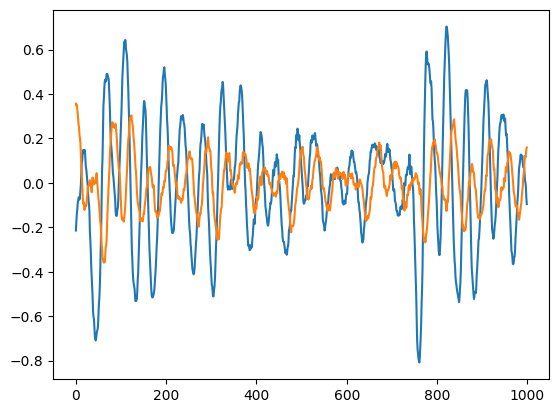

In [4]:
plt.plot(test_sample[0,0:1000,[0,6]])

In [5]:
model = RateDistortionAutoEncoder().to("cuda")
parameters = set(p for n, p in model.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in model.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.AdamW(parameters, lr=1e-4)
aux_optimizer = optim.AdamW(aux_parameters, lr=1e-3)
λ = 1e-5

In [6]:
sum(p.numel() for p in model.encode.parameters())

134400

Output()

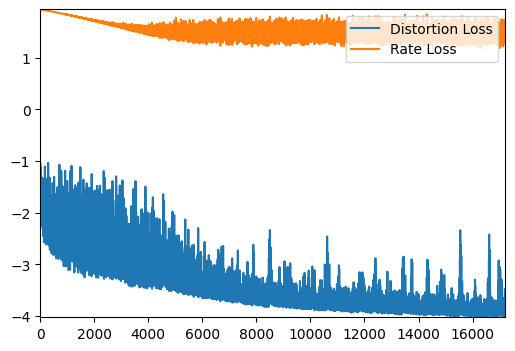

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x757aab55d660>>
Traceback (most recent call last):
  File "/home/dgj335/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x757aab55d660>>
Traceback (most recent call last):
  File "/home/dgj335/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7579c5dcdf30>
Traceback (most recent call last):
  File "/home/dgj335/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/dgj335/.

In [7]:
epochs = 50
mb = master_bar(range(epochs))
mb.names = ['Distortion Loss', 'Rate Loss']
dist_losses, rate_losses = [], []
output_plot = Output()
display(output_plot)
model.train()

desired_batch_size = 6
actual_batch_size = 6
accumulation_steps = desired_batch_size // actual_batch_size

for i_epoch in mb:
    dataloader = DataLoader(train_dataset, batch_size=actual_batch_size, shuffle=True, drop_last=True, num_workers=24)
    
    for i, batch in enumerate(progress_bar(dataloader, parent=mb)):
        x = batch['audio'].permute(0,2,1).to("cuda").to(torch.float)        
        x_hat, y_likelihoods = model(x)
        N, _, L = x.size()
        num_samples = N * L
        rate_loss = torch.log(y_likelihoods).sum() / (-torch.log(torch.tensor(2)) * num_samples)
        dist_loss = F.mse_loss(x, x_hat)
        loss = dist_loss +  λ * rate_loss

        loss.backward()
        model.aux_loss().backward()
        if (i + 1) % accumulation_steps == 0: 
            optimizer.step()
            aux_optimizer.step()
            optimizer.zero_grad()
            aux_optimizer.zero_grad()

        dist_losses.append(np.log10(dist_loss.item()))
        rate_losses.append(np.log10(rate_loss.item()))
        
        if (i + 1) % 4 == 0:
            
            mb.update_graph(
                [[range(len(dist_losses)), dist_losses], [range(len(rate_losses)), rate_losses]],
                [0, i_epoch*len(dataloader)+i+1],
                [min(min(dist_losses), min(rate_losses)), max(max(dist_losses), max(rate_losses))]
            )
            with torch.no_grad():
                test_sample = valid_dataset[30]['audio'].unsqueeze(0)
                test_input = test_sample.permute(0,2,1).to("cuda")
                test_output = model.encode(test_input).round()
                bytes_compressed = len(zlib.compress(test_output.to(torch.int8).cpu().numpy().tobytes(),level=9))
                compression_ratio = 2*L/bytes_compressed
                print(f"Compression Ratio: {compression_ratio}",end="\r")
                test_output = model.decode(test_output)
                test_output = test_output.permute(0,2,1).cpu()

            with output_plot:
                output_plot.clear_output(wait=True)
                plt.figure(figsize=(16, 6),dpi=100)
                plt.plot(test_sample[0,39500:40000,0].numpy(), color='blue')
                plt.plot(test_sample[0,39500:40000,6].numpy(), color='red')
                plt.plot(test_output[0,39500:40000,0].numpy(), color='green',alpha=0.7)
                plt.plot(test_output[0,39500:40000,6].numpy(), color='purple',alpha=0.7)
                plt.show()

    torch.save({
            'epoch': i_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'aux_optimizer_state_dict': aux_optimizer.state_dict(),
            'rate_losses': rate_losses,
            'dist_losses': dist_losses,
        }, f"checkpoint{i_epoch}.pth")

Output()

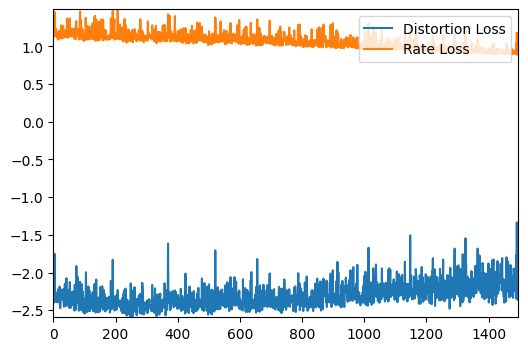

In [ ]:
λ=0.01
epochs = 50
mb = master_bar(range(epochs))
mb.names = ['Distortion Loss', 'Rate Loss']
dist_losses, rate_losses = [], []
output_plot = Output()
display(output_plot)
model.train()

desired_batch_size = 6
actual_batch_size = 6
accumulation_steps = desired_batch_size // actual_batch_size

for i_epoch in mb:
    dataloader = DataLoader(train_dataset, batch_size=actual_batch_size, shuffle=True, drop_last=True, num_workers=24)
    
    for i, batch in enumerate(progress_bar(dataloader, parent=mb)):
        x = batch['audio'].permute(0,2,1).to("cuda").to(torch.float)        
        x_hat, y_likelihoods = model(x)
        N, _, L = x.size()
        num_samples = N * L
        rate_loss = torch.log(y_likelihoods).sum() / (-torch.log(torch.tensor(2)) * num_samples)
        dist_loss = F.mse_loss(x, x_hat)
        loss = dist_loss +  λ * rate_loss

        loss.backward()
        model.aux_loss().backward()
        if (i + 1) % accumulation_steps == 0: 
            optimizer.step()
            aux_optimizer.step()
            optimizer.zero_grad()
            aux_optimizer.zero_grad()

        dist_losses.append(np.log10(dist_loss.item()))
        rate_losses.append(np.log10(rate_loss.item()))
        
        if (i + 1) % 4 == 0:
            
            mb.update_graph(
                [[range(len(dist_losses)), dist_losses], [range(len(rate_losses)), rate_losses]],
                [0, i_epoch*len(dataloader)+i+1],
                [min(min(dist_losses), min(rate_losses)), max(max(dist_losses), max(rate_losses))]
            )
            with torch.no_grad():
                test_sample = valid_dataset[30]['audio'].unsqueeze(0)
                test_input = test_sample.permute(0,2,1).to("cuda")
                test_output = model.encode(test_input).round()
                bytes_compressed = len(zlib.compress(test_output.to(torch.int8).cpu().numpy().tobytes(),level=9))
                compression_ratio = 2*L/bytes_compressed
                print(f"Compression Ratio: {compression_ratio}",end="\r")
                test_output = model.decode(test_output)
                test_output = test_output.permute(0,2,1).cpu()

            with output_plot:
                output_plot.clear_output(wait=True)
                plt.figure(figsize=(16, 6),dpi=100)
                plt.plot(test_sample[0,39500:40000,0].numpy(), color='blue')
                plt.plot(test_sample[0,39500:40000,6].numpy(), color='red')
                plt.plot(test_output[0,39500:40000,0].numpy(), color='green',alpha=0.7)
                plt.plot(test_output[0,39500:40000,6].numpy(), color='purple',alpha=0.7)
                plt.show()

    torch.save({
            'epoch': i_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'aux_optimizer_state_dict': aux_optimizer.state_dict(),
            'rate_losses': rate_losses,
            'dist_losses': dist_losses,
        }, f"checkpoint{i_epoch}.pth")